In [1]:
import pandas as pd
from torch.utils.data import DataLoader
import torch
import pytorch_lightning as pl
#from pytorch_lightning.profiler import Profiler, AdvancedProfiler
import HeatfluxData as hfd
import HeatfluxModel as hfm

In [2]:
filename_data = f'./Data/scaled_QdataKn23width100microns.csv'
# NOTE: if the filename_data does not exist generate it by `python3 generate_QimpactTrainingData.py 100 0.01 0.19 40000 110`
# Using the heat flux data module
scaled_Qdata = pd.read_csv(filename_data, header=0, index_col=0)
dropouts =  ['Kn', 'x']; Nfields = 6 - len(dropouts) # T, gradT, Z, n, - Kn, x
test_split = 0.5
train_split = 0.8
test_set, train_set, validation_set, vis_set = hfd.heat_flux_datasets(scaled_Qdata, test_split, train_split, dropouts)

Dropping Kn_0
Dropping Kn_1
Dropping Kn_2
Dropping Kn_3
Dropping Kn_4
Dropping Kn_5
Dropping Kn_6
Dropping Kn_7
Dropping Kn_8
Dropping Kn_9
Dropping Kn_10
Dropping Kn_11
Dropping Kn_12
Dropping Kn_13
Dropping Kn_14
Dropping Kn_15
Dropping Kn_16
Dropping Kn_17
Dropping Kn_18
Dropping Kn_19
Dropping Kn_20
Dropping Kn_21
Dropping Kn_22
Dropping x_0
Dropping x_1
Dropping x_2
Dropping x_3
Dropping x_4
Dropping x_5
Dropping x_6
Dropping x_7
Dropping x_8
Dropping x_9
Dropping x_10
Dropping x_11
Dropping x_12
Dropping x_13
Dropping x_14
Dropping x_15
Dropping x_16
Dropping x_17
Dropping x_18
Dropping x_19
Dropping x_20
Dropping x_21
Dropping x_22


In [3]:
### Create data loaders
train_loader = DataLoader(dataset = train_set, batch_size = 128)
validation_loader = DataLoader(dataset = validation_set, batch_size = 128)
test_loader = DataLoader(dataset = test_set, batch_size = 128)
# Special object for visualization
vis_loader = DataLoader(dataset = vis_set, batch_size = 128)

In [4]:
### Read the data sacling (generated by the data manager)
data_scaling = pd.read_csv(f'./Data/data_scaling.csv', header=0, index_col=0)

In [5]:
#### Create the heat flux model
Nfeatures = train_set[0][0].size()[0]# TODO: find a better way than extracting the size via Tensor
print(f'Nfeatures {Nfeatures}')
Nlayers = [30, 30]
NNmodelargs = pd.Series([Nfeatures, Nlayers, data_scaling, Nfields], dtype=object)
NNmodelargs.to_pickle('./NN/NN_model_args.pkl')
model = hfm.AlphaBetaModel(*NNmodelargs)

Nfeatures 92


In [6]:
### Let's train the beast!
from IPython.utils import io
with io.capture_output() as captured:
    trainer = pl.Trainer(max_epochs = 100)
    trainer.fit(model, train_loader, validation_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type    | Params
-------------------------------------
0 | fcIn     | Linear  | 2.8 K 
1 | fcOut    | Linear  | 62    
2 | mse_loss | MSELoss | 0     
-------------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.011     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


In [7]:
### Test the beast
# Get model prediction of heat flux values from visualization data set vis_set
values_prediction = model.heatflux_model(vis_set[:][0])
# Convert to numpy ndarray
values_prediction = values_prediction.detach().numpy()

In [8]:
# Add local flux evaluation
values_local = model.local_heatflux_model(vis_set[:][0])
values_local = values_local.detach().numpy()
# Local flux using beta
values_beta_local = model.local_heatflux_beta_model(vis_set[:][0])
values_beta_local = values_beta_local.detach().numpy()

In [9]:
# Add alpha and beta evaluation
values_alpha = model.alpha_model(vis_set[:][0])
values_alpha = values_alpha.detach().numpy()
values_beta = model.beta_model(vis_set[:][0])
values_beta = values_beta.detach().numpy()

In [10]:
# Get actual heat flux values from the data using back scaling
mean = data_scaling['Q']['mean']
std = data_scaling['Q']['std']
Q_actual = vis_set[:][1][:, 0]
beta_actual = vis_set[:][1][:, 1]
values_Q_actual = Q_actual * std + mean
# Convert to numpy ndarray
values_Q_actual = values_Q_actual.detach().numpy()
values_beta_actual = beta_actual.detach().numpy()

In [11]:
# Get plasma profiles
profiles = model.feature_xc(vis_set[:][0])
T_local = profiles['T']; gradT_local = profiles['gradT']
Z_local = profiles['Z']; n_local = profiles['n']
T_local = T_local.detach().numpy(); gradT_local = gradT_local.detach().numpy()
Z_local = Z_local.detach().numpy(); n_local = n_local.detach().numpy()

In [12]:
# TODO: get consistent x
import numpy as np
Npoints = len(values_prediction)
x = np.linspace(5e-3, 0.185, Npoints)

In [13]:
import physics as phys
flim_high = 0.17
xlim_high, Qlim_high = phys.QSHlimited(x, n_local, Z_local, T_local, flim_high)
flim_low = 0.03
xlim_low, Qlim_low = phys.QSHlimited(x, n_local, Z_local, T_local, flim_low)

*Output test*

alpha min / max: 0.04520951211452484 / 8.200063705444336


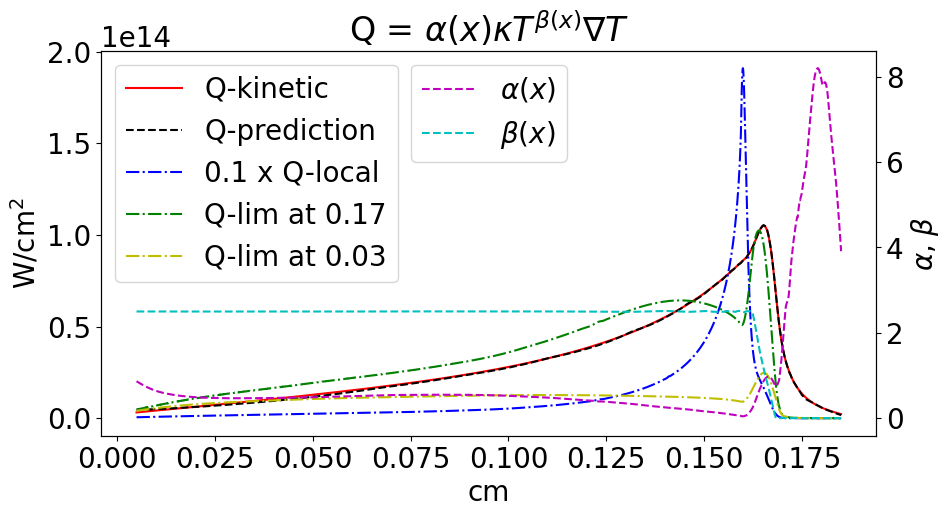

In [14]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 20})
# And finally we can see that our network has done a decent job of estimating!
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(x, values_Q_actual, 'r', label='Q-kinetic')
ax1.plot(x, values_prediction, 'k--', label='Q-prediction')
ax1.plot(x, 0.1 * values_local, 'b-.', label='0.1 x Q-local')
ax1.plot(xlim_high, Qlim_high, 'g-.', label=f'Q-lim at {flim_high}')
ax1.plot(xlim_low, Qlim_low, 'y-.', label=f'Q-lim at {flim_low}')
#ax1.plot(0.1 * values_beta_local, 'g--', label='0.1 x beta local')
ax1.set_xlabel('cm')
ax1.set_ylabel('W/cm$^2$')
plt.title(r'Q = $\alpha(x) \kappa T^{\beta(x)} \nabla T$')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel(r'$\alpha$, $\beta$')
ax2.plot(x, values_alpha, 'm--', label=r'$\alpha(x)$')
ax2.plot(x, values_beta, 'c--', label=r'$\beta(x)$')
ax2.legend(loc='upper center')

fig1.savefig("./graphs/heatflux.pdf")

print(f'alpha min / max: {min(values_alpha)} / {max(values_alpha)}')

alpha min / max: 0.04520951211452484 / 8.200063705444336


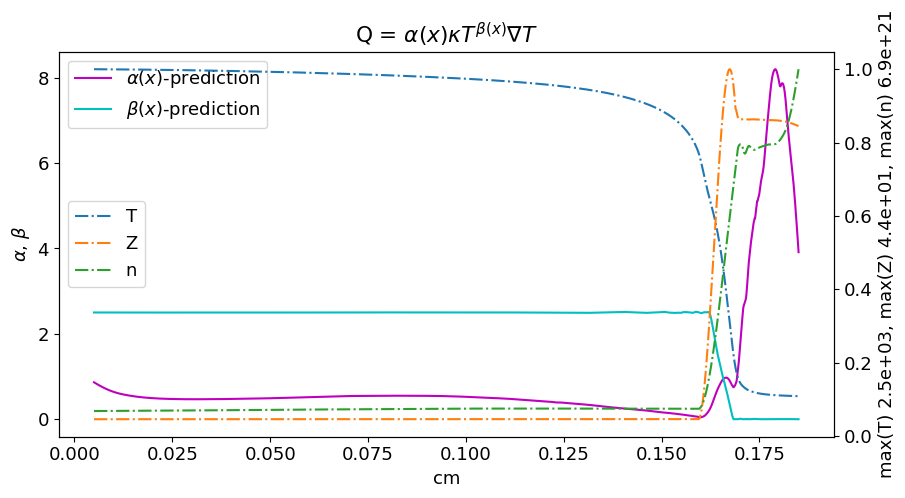

In [15]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 13})
# And finally we can see that our network has done a decent job of estimating!
fig1, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(x, values_alpha, 'm', label=r'$\alpha(x)$-prediction')
ax1.plot(x, values_beta, 'c', label=r'$\beta(x)$-prediction')
ax1.set_xlabel('cm')
ax1.set_ylabel(r'$\alpha$, $\beta$')
plt.title(r'Q = $\alpha(x) \kappa T^{\beta(x)} \nabla T$')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second y-axes that shares the same x-axes
ax2.plot(x, T_local / max(T_local), '-.', label="T")
ax2.plot(x, Z_local / max(Z_local), '-.', label="Z")
ax2.plot(x, n_local / max(n_local), '-.', label="n")
ax2.set_ylabel(f'max(T) {max(T_local):.1e}, max(Z) {max(Z_local):.1e}, max(n) {max(n_local):.1e}')
ax2.legend(loc='center left')

fig1.savefig("./graphs/alphabeta.pdf")

print(f'alpha min / max: {min(values_alpha)} / {max(values_alpha)}')

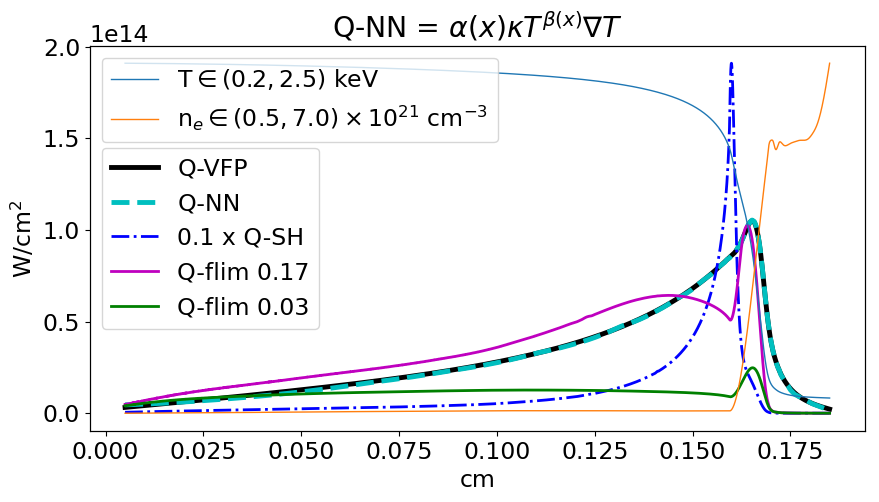

In [16]:
plt.rcParams.update({'font.size': 17})
lw_heatflux1 = 3.5
lw_heatflux2 = 2.0
lw_plasma = 1.0
# And finally we can see that our network has done a decent job of estimating!
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(x, values_Q_actual, 'k-', lw=lw_heatflux1, label='Q-VFP')
ax1.plot(x, values_prediction, 'c--', lw=lw_heatflux1, label='Q-NN')
ax1.plot(x, 0.1 * values_local, 'b-.', lw=lw_heatflux2, label='0.1 x Q-SH')
ax1.plot(xlim_high, Qlim_high, 'm-', lw=lw_heatflux2, label=f'Q-flim {flim_high}')
ax1.plot(xlim_low, Qlim_low, 'g-', lw=lw_heatflux2, label=f'Q-flim {flim_low}')
#ax1.plot(0.1 * values_beta_local, 'g--', label='0.1 x beta local')
ax1.set_xlabel('cm')
ax1.set_ylabel('W/cm$^2$')
plt.title(r'Q-NN = $\alpha(x) \kappa T^{\beta(x)} \nabla T$')
ax1.legend(loc='center left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, T_local / max(T_local), '-', lw=lw_plasma, label=r'T$\in (0.2, 2.5)$ keV')
ax2.plot(x, n_local / max(n_local), '-', lw=lw_plasma, label=r'n$_e \in (0.5, 7.0)\times 10^{21}$ cm$^{-3}$')
#ax2.set_ylabel(f'max(T) {max(T_local):.1e}, max(n) {max(n_local):.1e}')
#ax2.plot(x, Z_local / max(Z_local), ':', label="Z")
#ax2.set_ylabel(f'max(T) {max(T_local):.1e}, max(Z) {max(Z_local):.1e}, max(n) {max(n_local):.1e}')
ax2.legend(loc='upper left')
ax2.set_yticklabels([]); ax2.set_yticks([])

fig.savefig("./graphs/heatflux-profiles.pdf")

c:\Users\aleks\Projects\nonloc from cluster\nonloc_heatflux\PyTorch\physics.py:50: RuntimeWarning: invalid value encountered in power
  return c * (1.0 - b * x**2.0)**(1.0 / abs(beta))


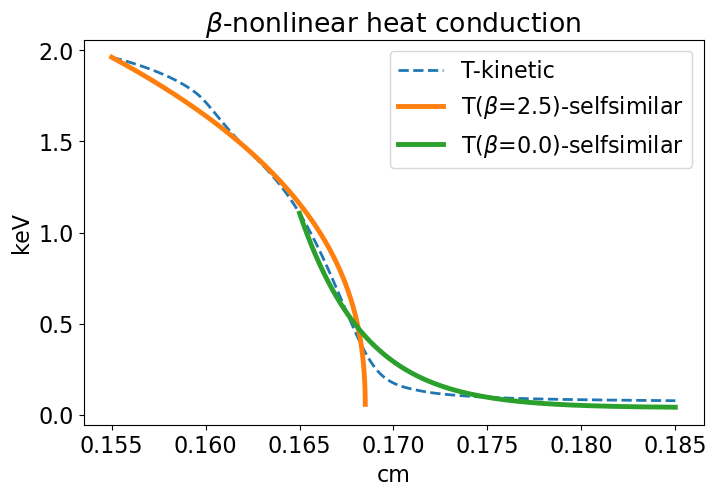

In [17]:
plt.rcParams.update({'font.size': 16})
lw_plasma = 2.0
lw_T = 3.5

# Set x range via min value
xmin = 0.155

# Work in keeV
Te = T_local * 1e-3 - 0.2

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x[x>xmin], Te[x>xmin], '--', lw=lw_plasma, label="T-kinetic")

# Set bounding points
x0 = xmin
x1 = 0.1685
T0 = max(Te[x>xmin])
T1 = 0.0 # Foot of the nonlinear heat wave
ax.plot(x[x>xmin], phys.Tselfsimilar_beta(x0, T0, x1, T1, x[x>xmin], 2.5), '-', lw=lw_T, label=r'T($\beta$=2.5)-selfsimilar')

# Set bounding points
xmin = 0.165
Tshift = 0.5 * min(Te) # Reduce artificial T flattening in Impact due to f1 = 0 BC. 
x0 = xmin 
x1 = 0.175 #x[len(x)-1]
T0 = max(Te[x>xmin]) - Tshift
T1 = max(Te[x>=x1]) - Tshift
ax.plot(x[x>xmin], phys.Tselfsimilar_beta(x0, T0, x1, T1, x[x>xmin], 1e-3) + Tshift, '-', lw=lw_T, label=r'T($\beta$=0.0)-selfsimilar')

ax.legend(loc='upper right')

ax.set_xlabel('cm')
ax.set_ylabel('keV')

plt.title(r'$\beta$-nonlinear heat conduction')

fig.savefig("./graphs/T-beta.pdf")

# Trying to find out why $\alpha$ is so different in heatcond

In [18]:
init_profile=pd.read_csv('./Data/init_profile.csv', index_col=(0))
#init_profile=init_profile.iloc[::50,:]
#init_profile.reset_index(drop=True, inplace=True)
init_profile=init_profile.iloc[::100,:]


nescaled  = (init_profile['ne']-data_scaling['n'].loc['mean'])/data_scaling['n'].loc['std']
Zscaled = (init_profile['Zbar']-data_scaling['Z'].loc['mean'])/data_scaling['Z'].loc['std']
Knscaled  = (init_profile['Kn']-data_scaling['Kn'].loc['mean'])/data_scaling['Kn'].loc['std']
Tscaled  = (init_profile['Te']-data_scaling['T'].loc['mean'])/data_scaling['T'].loc['std']
gradTscaled  = (init_profile['gradTe']-data_scaling['gradT'].loc['mean'])/data_scaling['gradT'].loc['std'] 
xdsd=np.array(init_profile['x'])



In [19]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
import importlib
import heatConduction as hc
importlib.reload(hc)
import parameter as param
importlib.reload(param)
para = param.main(model)
#para = param.main(NN_training.train_model(100))
def get_data_qless(para, x, T, gradT, Z, n, Kn, lng):  
    numFields = 4 #T, gradT, Z, n, -  Kn,  x
    Qdata=np.empty((0,numFields*lng), int) #2 * rad "#of points in interval" * 5 "for each phsy quantity" + 2 "for Q and beta"
    for ind, _ in enumerate(x):  #x_min=x[ind], x_max=x[ind+2*rad], x_c=x[ind+rad]
        datapoint=np.array([])          
        if ind+lng>=len(x)+1:
            break    
        else: #TODO: the number of appended quantities is depended on the dropouts in NN-heatflux.ipynb or NN_training.py !!!
            datapoint=np.append(datapoint, T.iloc[ind:ind+lng]) #append all Te in xmin-xmax
            datapoint=np.append(datapoint, gradT[ind:ind+lng]) #append all gradTe in xmin-xmax
            datapoint=np.append(datapoint, Z.iloc[ind:ind+lng]) #append all Zbar in xmin-xmax
            datapoint=np.append(datapoint, n.iloc[ind:ind+lng]) #append all gradTe in xmin-xmax
            #datapoint=np.append(datapoint, Kn.iloc[ind:ind+lng])
            #datapoint=np.append(datapoint, x[ind:ind+lng])
            # TODO: what is the appropriate scaling here? Global (max(x)-min(x)) might be to large!
            Qdata=np.append(Qdata,[datapoint], axis=0)
            # if ind%5000==0:
            #     print(f"We're done with {ind}/{len(x)-lng+1} points") 
    #Qdata =torch.tensor(np.c_[Qdata, np.empty([len(Qdata), lng])]).float()
    heatflux = para['NNmodel'].heatflux_model(torch.tensor(Qdata).float()).detach().numpy()
    alphas=para['NNmodel'].alpha_model(torch.tensor(Qdata).float()).detach().numpy()
    betas=para['NNmodel'].beta_model(torch.tensor(Qdata).float()).detach().numpy()
    for i in range(int((len(x)-len(alphas))/2)):              
        alphas = np.append(alphas[0], alphas)
        betas = np.append(betas[0], betas)
    for i in range(int((len(x)-(ind-1))/2)):              
        alphas = np.append(alphas, alphas[-1])
        betas = np.append(betas, betas[-1])
    return alphas, betas, Qdata, lng, int((len(x)-len(alphas))/2), int((len(x)-(ind-1))/2), heatflux

# Default kernel size is 100 microns

albas, bebas, datann, lng, margin, marginend, hflx = get_data_qless(para,xdsd, Tscaled, gradTscaled,Zscaled, \
                                        nescaled, Knscaled, int(para['NNmodel'].fcIn.in_features/4))
                                        

# alphas=model.alpha_model(torch.tensor(datann).float()).detach().numpy()
# betas=model.beta_model(torch.tensor(datann).float()).detach().numpy()

In [20]:
hflx.tofile('./Data/hflx.csv', sep=',')

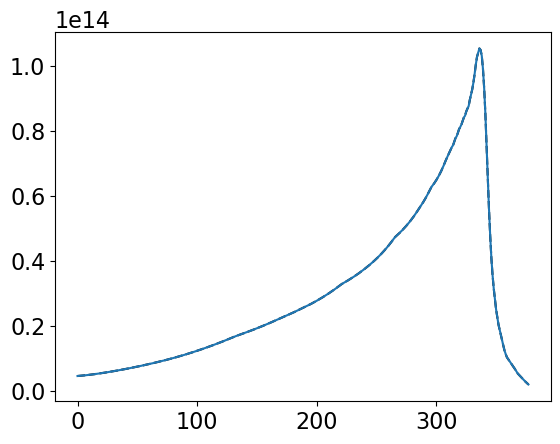

In [21]:
plt.plot(values_prediction[::100], 'k--', label='Q-prediction')
plt.plot(hflx)

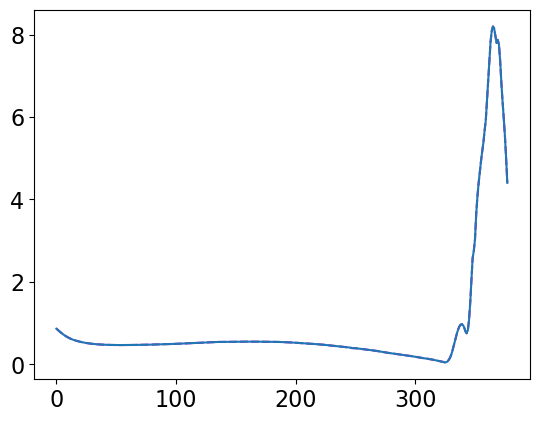

In [22]:
plt.plot(values_alpha[::100], 'm--', label=r'$\alpha(x)$')
plt.plot(albas[margin+11:-marginend])

In [25]:
model.fcIn.in_features/4

23.0

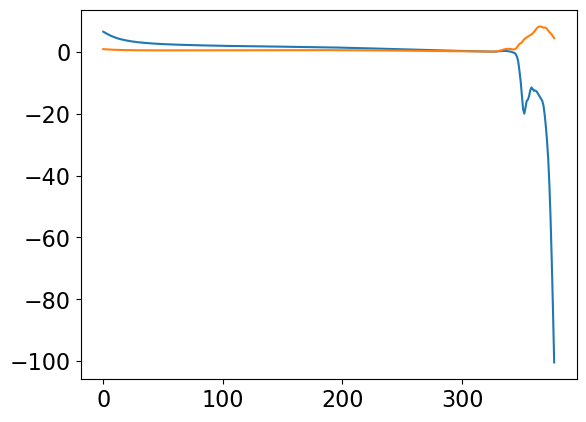

In [23]:
torch.save(model.state_dict(), './NN/Model.pt')
model_loaded=hfm.AlphaBetaModel(*pd.read_pickle('./NN/NN_model_args.pkl'))
model_loaded.load_state_dict(torch.load('./NN/Model.pt'))
with torch.no_grad():
    model_loaded.eval()


alphas_loaded=model_loaded.alpha_model(torch.tensor(datann).float()).detach().numpy()
alphas=model.alpha_model(torch.tensor(datann).float()).detach().numpy()

plt.plot(alphas_loaded)
plt.plot(alphas)

In [24]:
model_loaded.parameters()==model.parameters()
# alhas=model.alpha_model(torch.tensor(datann).float()).detach().numpy()
# plt.plot(alhas)
# #plt.plot(betas)
# plt.plot(albas[10:-10])

False